In [51]:
# Importing Necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [52]:
# Define the base URL for the Johns Hopkins dataset

base_url = "https://github.com/CSSEGISandData/COVID-19.git"

In [53]:
confirmed_url = base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

In [54]:
# Loading the dataset

confirmed_df = pd.read_csv(base_url + "time_series_covid19_confirmed_global.csv")
deaths_df = pd.read_csv(base_url + "time_series_covid19_deaths_global.csv")
recovered_df = pd.read_csv(base_url + "time_series_covid19_recovered_global.csv")

print("Datasets loaded succesfully:")
print(f"confirmed dataset shape: {confirmed_df.shape}")
print(f"deaths dataset shape: {deaths_df.shape}")
print(f"recovered dataset shape: {recovered_df.shape}")

Datasets loaded succesfully:
confirmed dataset shape: (289, 1147)
deaths dataset shape: (289, 1147)
recovered dataset shape: (274, 1147)


In [55]:
# DATA EXPLORATION

print("Confirmed Case Data")
confirmed_df.head()

confirmed_df.info()

# Data for a specific country, e.g., India
india_data = confirmed_df[confirmed_df['Country/Region'] == 'India']
india_data.head()

Confirmed Case Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Columns: 1147 entries, Province/State to 3/9/23
dtypes: float64(2), int64(1143), object(2)
memory usage: 2.5+ MB


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
148,NaN,India,20.593684,78.96288,0,0,0,0,0,0,...,44687837,44688105,44688388,44688722,44689046,44689327,44689593,44689919,44690298,44690738


In [56]:
# Get the latest date column name
latest_date = confirmed_df.columns[-1]
total_confirmed_latest = confirmed_df[latest_date].sum()
print(f"Total confirmed cases as of {latest_date}: {total_confirmed_latest:,}")

Total confirmed cases as of 3/9/23: 676,570,149


In [57]:
# Check for missing values

print("Missing values in Confirmed dataset:")
print(confirmed_df.isnull().sum().sum())

display(confirmed_df.info())
display(confirmed_df.isnull().sum().sort_values(ascending=False).head(20))


Missing values in Confirmed dataset:
202
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Columns: 1147 entries, Province/State to 3/9/23
dtypes: float64(2), int64(1143), object(2)
memory usage: 2.5+ MB


None

,0
Province/State,198
Lat,2
Long,2
2/25/22,0
2/24/22,0
2/23/22,0
2/22/22,0
2/21/22,0
2/20/22,0
2/19/22,0


In [58]:
# Cleaning the missing values

confirmed_df['Province/State'].fillna(confirmed_df['Country/Region'], inplace=True)
deaths_df['Province/State'].fillna(deaths_df['Country/Region'], inplace=True)
recovered_df['Province/State'].fillna(recovered_df['Country/Region'], inplace=True)

def fill_missing_coordinates(df):
    df_filled = df.copy()

    country_coords = df_filled.groupby('Country/Region').agg({
        'Lat': 'mean',
        'Long': 'mean'
    }).reset_index()

    coord_mapping = country_coords.set_index('Country/Region').to_dict('index')

    for idx, row in df_filled.iterrows():
        if pd.isna(row['Lat']) or pd.isna(row['Long']):
           country = row['Country/Region']
           if country in coord_mapping:
               df_filled.at[idx, 'Lat'] = coord_mapping[country]['Lat']
               df_filled.at[idx, 'Long'] = coord_mapping[country]['Long']

    return df_filled

confirmed_df_filled = fill_missing_coordinates(confirmed_df)
deaths_df_filled = fill_missing_coordinates(deaths_df)
recovered_df_filled = fill_missing_coordinates(recovered_df)

print("Missing coordinates filled with country averages:")

confirmed_df = confirmed_df_filled
deaths_df = deaths_df_filled
recovered_df = recovered_df_filled

Missing coordinates filled with country averages:


In [59]:
# Melt the data to convert date columns into rows

id_vars = ['Province/State', 'Country/Region', 'Lat', 'Long']
value_vars = confirmed_df.columns[4:]

confirmed_long = confirmed_df.melt(id_vars=id_vars, value_vars=value_vars, var_name='Date', value_name='Confirmed')
deaths_long = deaths_df.melt(id_vars=id_vars, value_vars=value_vars, var_name='Date', value_name='Deaths')
recovered_long = recovered_df.melt(id_vars=id_vars, value_vars=value_vars, var_name='Date', value_name='Recovered')

covid_df = confirmed_long
covid_df['Deaths'] = deaths_long['Deaths']
covid_df['Recovered'] = recovered_long['Recovered']

covid_df['Date'] = pd.to_datetime(covid_df['Date'])

print("Data Processing Complete:")
covid_df.head()



Data Processing Complete:


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,Afghanistan,Afghanistan,33.93911,67.709953,2020-01-22,0,0,0.0
1,Albania,Albania,41.15330,20.168300,2020-01-22,0,0,0.0
2,Algeria,Algeria,28.03390,1.659600,2020-01-22,0,0,0.0
3,Andorra,Andorra,42.50630,1.521800,2020-01-22,0,0,0.0
4,Angola,Angola,-11.20270,17.873900,2020-01-22,0,0,0.0


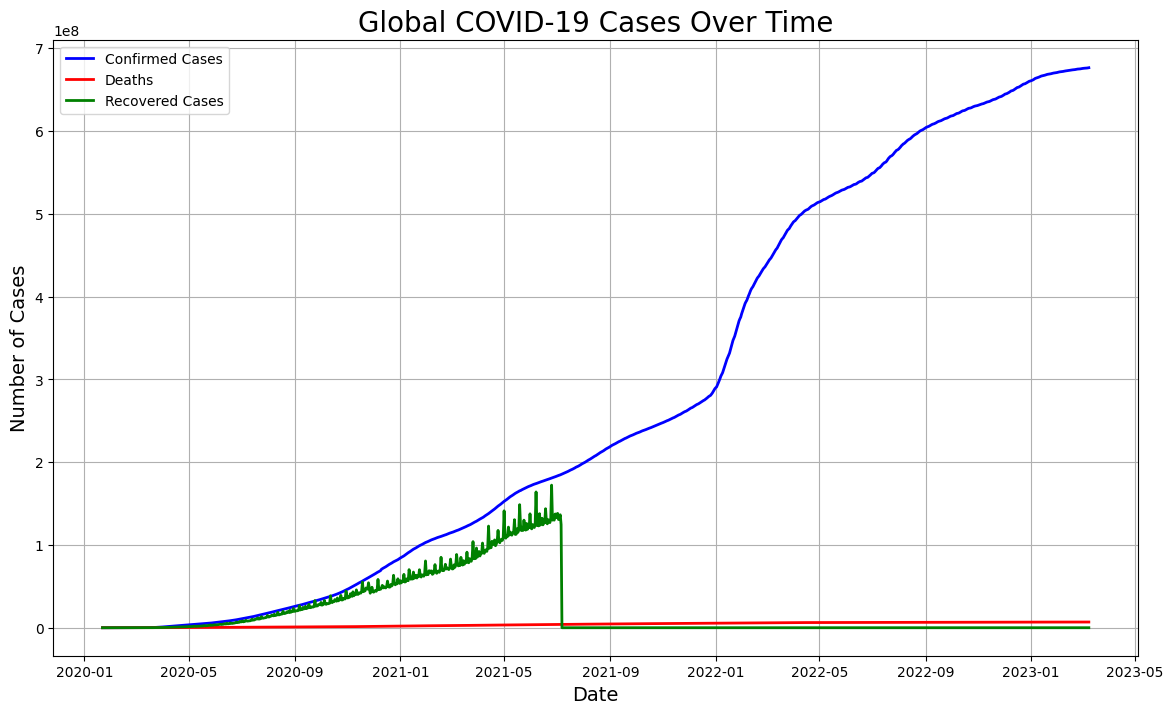

In [60]:
## EXPLORATORY DATA ANALYSIS

# Global Case Growth Trend (Line Chart):

global_trend = covid_df.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
global_trend['Active'] = global_trend['Confirmed'] - global_trend['Deaths'] - global_trend['Recovered']

plt.figure(figsize=(14, 8))
plt.plot(global_trend['Date'], global_trend['Confirmed'], label='Confirmed Cases', linewidth=2, color='blue')
plt.plot(global_trend['Date'], global_trend['Deaths'], label='Deaths', linewidth=2, color='red')
plt.plot(global_trend['Date'], global_trend['Recovered'], label='Recovered Cases', linewidth=2, color='green')
plt.title('Global COVID-19 Cases Over Time', size=20)
plt.xlabel('Date', size=14)
plt.ylabel('Number of Cases', size=14)
plt.legend()
plt.grid(True)
plt.show()

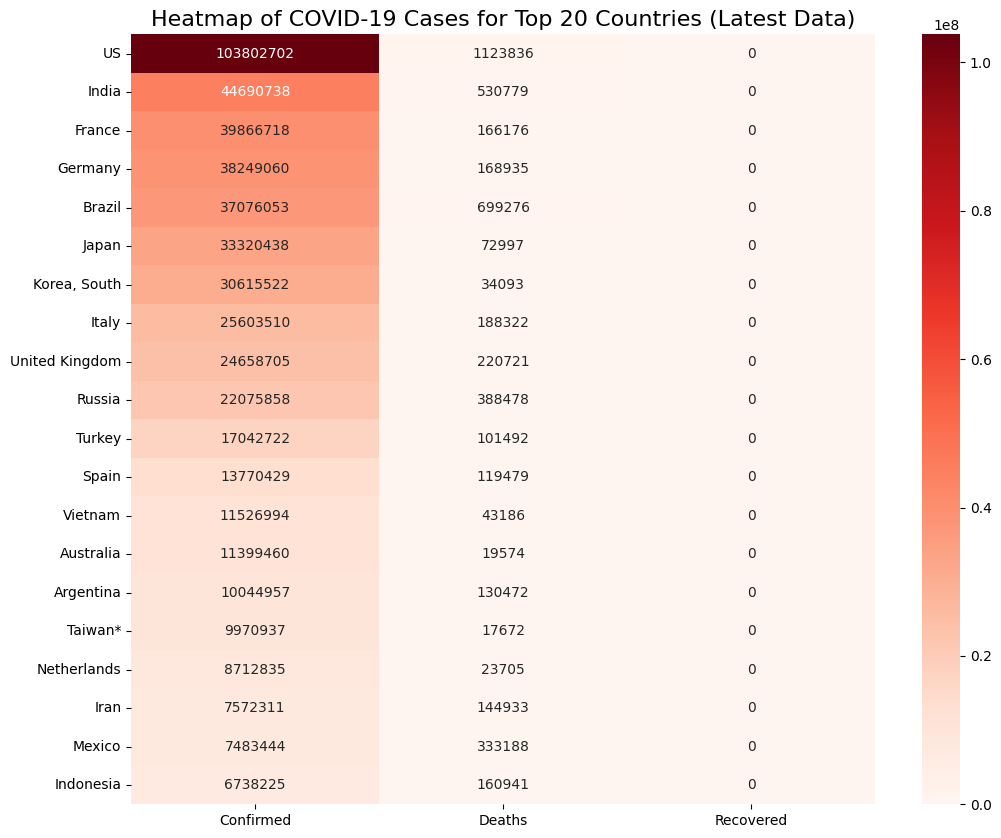

In [61]:
# Identify High-Risk Areas (Heatmap):

latest_data = covid_df[covid_df['Date'] == covid_df['Date'].max()]
country_totals = latest_data.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().sort_values('Confirmed', ascending=False).reset_index()

top_20_countries = country_totals.head(20)

plt.figure(figsize=(12, 10))
sns.heatmap(top_20_countries[['Confirmed', 'Deaths', 'Recovered']], annot=True, fmt=".0f", cmap='Reds', xticklabels=True, yticklabels=top_20_countries['Country/Region'])
plt.title('Heatmap of COVID-19 Cases for Top 20 Countries (Latest Data)', size=16)
plt.show()

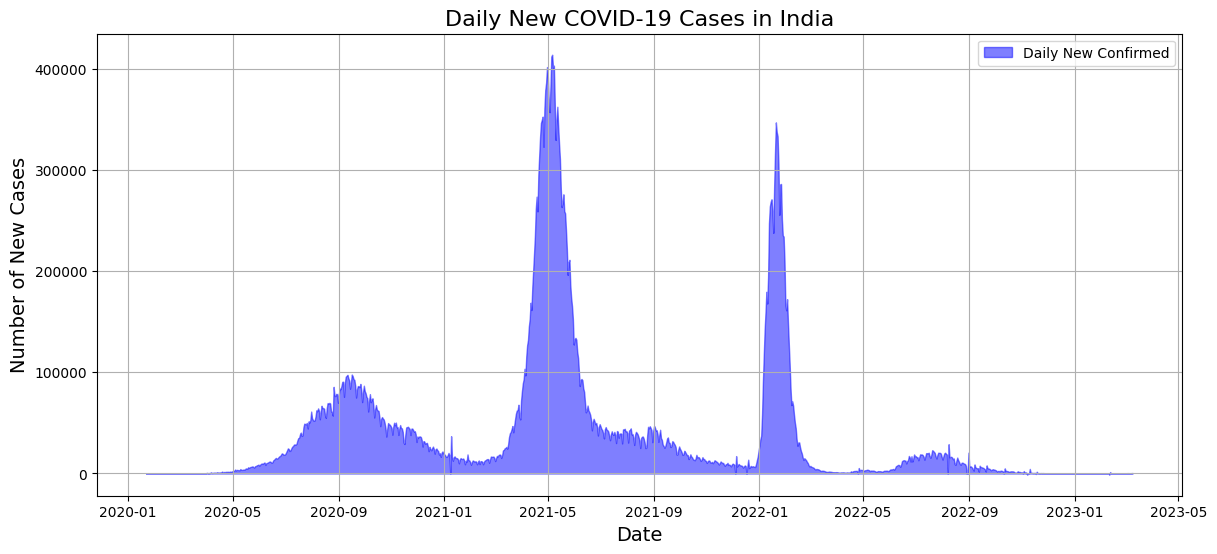

In [62]:
# Analysis for a specific country, e.g., India

india_df = covid_df[covid_df['Country/Region'] == 'India']
india_daily = india_df.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum().diff().reset_index()
india_daily.fillna(0, inplace=True)

plt.figure(figsize=(14, 6))
plt.fill_between(india_daily['Date'], india_daily['Confirmed'], color='blue', alpha=0.5, label='Daily New Confirmed')
plt.title('Daily New COVID-19 Cases in India', size=16)
plt.xlabel('Date', size=14)
plt.ylabel('Number of New Cases', size=14)
plt.legend()
plt.grid(True)
plt.show()


In [63]:
## FEATURE SELECTION & ADAVNCED ANALYSIS

# Calculate Recovery and Fatality Rates:

latest_data['Fatality_Rate'] = (latest_data['Deaths'] / latest_data['Confirmed']) * 100
latest_data['Recovery_Rate'] = (latest_data['Recovered'] / latest_data['Confirmed']) * 100

high_fatality = latest_data[latest_data['Confirmed'] > 1000].nlargest(10, 'Fatality_Rate')
print(high_fatality)

high_recovery = latest_data[latest_data['Confirmed'] > 1000].nlargest(10, 'Recovery_Rate')
print(high_recovery)


                Province/State          Country/Region        Lat        Long  \
330324                   Yemen                   Yemen  15.552727   48.516388   
330281                   Sudan                   Sudan  12.862800   30.217600   
330110                   Hubei                   China  30.975600  112.270700   
330286                   Syria                   Syria  34.802075   38.996815   
330127                 Unknown                   China  32.887645  111.785991   
330276                 Somalia                 Somalia   5.152149   46.199616   
330253                    Peru                    Peru  -9.190000  -75.015200   
330149                   Egypt                   Egypt  26.820553   30.802498   
330223                  Mexico                  Mexico  23.634500 -102.552800   
330067  Bosnia and Herzegovina  Bosnia and Herzegovina  43.915900   17.679100   

             Date  Confirmed  Deaths  Recovered  Fatality_Rate  Recovery_Rate  
330324 2023-03-09      11945

In [64]:
## World Bank API URL for population density
# Using the World Bank data for further analysis

import requests
import io
from scipy import stats
import zipfile

web_url = "https://data.worldbank.org/indicator/EN.POP.DNST"

def download_worldbank_population_density():
    wb_url = "https://api.worldbank.org/v2/en/indicator/EN.POP.DNST?downloadformat=csv"

    try:
        print("Downloading World Bank population density data...")
        response = requests.get(wb_url)
        response.raise_for_status()

        # Extracting the zip file
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            csv_files = [f for f in z.namelist() if f.endswith('.csv') and 'Metadata' not in f]
            if csv_files:
                with z.open(csv_files[0]) as f:
                    wb_data = pd.read_csv(f, skiprows=4)
                print("World Bank data downloaded successfully!")
                return wb_data
            else:
                print("No CSV file found in the download")
                return None
    except Exception as e:
        print(f"Error downloading World Bank data: {e}")
        return None

wb_pop_density = download_worldbank_population_density()

if wb_pop_density is not None:
    print("World Bank Data Structure:")
    print(wb_pop_density.head())
    print(f"\nDataset shape: {wb_pop_density.shape}")
    print(f"Columns: {wb_pop_density.columns.tolist()}")

World Bank data downloaded successfully!
World Bank Data Structure:
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                                      Indicator Name Indicator Code  1960  \
0  Population density (people per sq. km of land ...    EN.POP.DNST   NaN   
1  Population density (people per sq. km of land ...    EN.POP.DNST   NaN   
2  Population density (people per sq. km of land ...    EN.POP.DNST   NaN   
3  Population density (people per sq. km of land ...    EN.POP.DNST   NaN   
4  Population density (people per sq. km of land ...    EN.POP.DNST   NaN   

         1961        1962        1963        1964        1965  ...  \
0  308.766667  312.888889  316.677778  320.105556  323.277778  ...   
1   12.036017   12.363810   12.703964   13.060

In [65]:
## Process the World Bank data to extract population density

# Process the World Bank data to match our COVID-19 analysis format
def process_worldbank_data(wb_df, target_year=2020):
    """
    Process the World Bank population density data for COVID-19 analysis
    """

    # Finding the column for the target year (it might be named '2020', '2020 [YR2020]', etc.)
    year_columns = [col for col in wb_df.columns if str(target_year) in col]

    if not year_columns:
        print(f"No population density data found for the year {target_year}")
        print("Available year columns:", [col for col in wb_df.columns if any (char.isdigit() for char in str(col))])

        # Using the most recent available year
        numeric_cols = [col for col in wb_df.columns if wb_df.columns if str(col).replace('.','').isdigit()]
        if numeric_cols:
            target_year =  max([float(col) for col in numeric_cols])
            year_columns = [col for col in wb_df.columns if str(target_year) in col]
    if year_columns:
        density_column = year_columns[0]
        print(f"Using population density data found for the year {density_column}")
    else:              # If no specific year found, use the first numeric column after country info
        density_column = wb_df.columns[4]
        print(f"Using column: {density_column} for population density")

    # Select relevant columns
    processed_data = wb_df[['Country Name', 'Country Code', density_column]].copy()

    # Rename columns
    processed_data.columns = ['Country Name', 'Country Code', 'Population_Density']

    # Remove rows with missing values
    processed_data = processed_data.dropna(subset=['Population_Density'])

    # Create a mapping for country name variations (to match COVID-19 dataset)
    country_mapping = {
        'United States': 'US',
        'United Kingdom': 'UK',
        'Korea, Rep.': 'South Korea',
        'Korea, Republic of': 'South Korea',
        'Iran, Islamic Rep.': 'Iran',
        'Egypt, Arab Rep.': 'Egypt',
        'Russian Federation': 'Russia',
        'Viet Nam': 'Vietnam',
        'Brunei Darussalam': 'Brunei',
        'Myanmar': 'Burma',
        'Czech Republic': 'Czechia',
        'Slovak Republic': 'Slovakia',
        'Bahamas, The': 'Bahamas',
        'Gambia, The': 'Gambia',
        'Hong Kong SAR, China': 'Hong Kong',
        'Macao SAR, China': 'Macau'
    }

    # Apply country name mapping
    processed_data['Country/Region'] = processed_data['Country Name']
    processed_data['Country/Region'] = processed_data['Country/Region'].replace(country_mapping)

    print("Processed {len(processed_data)} countries with population density data")
    return processed_data

# Process the World Bank data
population_density_data = process_worldbank_data(wb_pop_density)
print("\nProcessed Population Density Data Sample:")
print(population_density_data.head(15))




Using population density data found for the year 2020
Processed {len(processed_data)} countries with population density data

Processed Population Density Data Sample:
                   Country Name Country Code  Population_Density  \
0                         Aruba          ABW          603.261111   
1   Africa Eastern and Southern          AFE           46.779514   
2                   Afghanistan          AFG           59.900616   
3    Africa Western and Central          AFW           52.463124   
4                        Angola          AGO           26.831741   
5                       Albania          ALB          103.571131   
6                       Andorra          AND          164.638298   
7                    Arab World          ARB           34.633910   
8          United Arab Emirates          ARE          132.371698   
9                     Argentina          ARG           16.513367   
10                      Armenia          ARM          105.027377   
11              

In [66]:
## Prepare COVID-19 data for merging

# Get the latest COVID-19 data by country
latest_covid_data = covid_df[covid_df['Date'] == covid_df['Date'].max()]
country_covid_totals = latest_covid_data.groupby('Country/Region')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

print("COVID-19 Country Totals (Latest Date):")
print(f"Total countries in COVID data: {len(country_covid_totals)}")
print(country_covid_totals.head())

COVID-19 Country Totals (Latest Date):
Total countries in COVID data: 201
  Country/Region  Confirmed  Deaths  Recovered
0    Afghanistan     209451    7896        0.0
1        Albania     334457    3598        0.0
2        Algeria     271496    6881        0.0
3        Andorra      47890     165        0.0
4         Angola     105288    1933        0.0


In [67]:
# Final integration with my COVID-19 analysis
def merge_covid_population_data(covid_df, population_df):
    """
    Merge COVID-19 data with population density data
    """
    # First merge attempt with exact country name matches
    merged_data = pd.merge(covid_df, population_df, on='Country/Region', how='inner')

    print(f"After initial merge: {len(merged_data)} countries matched")

    # Identify countries that didn't match
    covid_countries = set(covid_df['Country/Region'])
    matched_countries = set(merged_data['Country/Region'])
    unmatched_countries = covid_countries - matched_countries

    print(f"\nUnmatched_countries ({len(unmatched_countries)}):")
    print(list(unmatched_countries)[:20])

    return merged_data

# Perform the merge
merged_analysis_data = merge_covid_population_data(country_covid_totals, population_density_data)

print(f"\nFinal merged dataset: {len(merged_analysis_data)} countries")
print(merged_analysis_data.head())

After initial merge: 177 countries matched

Unmatched_countries (24):
['Holy See', 'Turkey', 'Korea, North', 'Micronesia', 'Congo (Kinshasa)', 'Saint Vincent and the Grenadines', 'Congo (Brazzaville)', 'Taiwan*', 'Kosovo', 'United Kingdom', 'Kyrgyzstan', 'Syria', 'Antarctica', 'Winter Olympics 2022', 'Venezuela', 'Somalia', 'MS Zaandam', 'Summer Olympics 2020', 'Diamond Princess', 'Yemen']

Final merged dataset: 177 countries
  Country/Region  Confirmed  Deaths  Recovered Country Name Country Code  \
0    Afghanistan     209451    7896        0.0  Afghanistan          AFG   
1        Albania     334457    3598        0.0      Albania          ALB   
2        Algeria     271496    6881        0.0      Algeria          DZA   
3        Andorra      47890     165        0.0      Andorra          AND   
4         Angola     105288    1933        0.0       Angola          AGO   

   Population_Density  
0           59.900616  
1          103.571131  
2           18.491561  
3          164.63

In [68]:
## Calculating additional metrics for fair comparison
# We need population data to calculate per capita metrics
# Let's add estimated population data for major countries
def add_population_data(merged_df):
    """
    Add population data for normalization

    """
    # Population Data for Major Countries (in millions)
    population_data = {
        'US': 342, 'India': 1464, 'Brazil': 213, 'Russia': 145, 'France': 69, 'Turkey': 86, 'UK': 69, 'Italy': 60, 'Spain': 49, 'Germany': 84, 'China': 1408, 'Japan': 124, 'Iran': 90, 'South Korea': 63, 'Vietnam': 100, 'Egypt': 109, 'Peru': 34, 'Canada': 42, 'Indonesia': 285, 'Saudi Arabia': 34, 'Maxico': 132, 'Argentina': 46, 'Chile': 20, 'Thailand': 71, 'Pakistan': 255, 'Bangladesh': 175, 'Philippines': 109, 'Iraq': 46, 'Israel': 9, 'Nigeria': 236, 'Malaysia': 34, 'Colombia': 51, 'South Africa': 63

    }

    merged_df['Total_Population_Million'] = merged_df['Country/Region'].map(population_data)

    # Remove countries without population data
    merged_df = merged_df.dropna(subset=['Total_Population_Million'])

    # Calculate normalized metrics
    merged_df['Confirmed_Per_Million'] = (merged_df['Confirmed'] / merged_df['Total_Population_Million'])
    merged_df['Deaths_Per_Million'] = merged_df['Deaths'] / (merged_df['Total_Population_Million'])
    merged_df['Cases_per_density_unit'] = merged_df['Confirmed_Per_Million'] / merged_df['Population_Density']

    print(f"Countries with complete data: {len(merged_df)}")
    return merged_df

# Add population data and calculate metrics
final_analysis_data = add_population_data(merged_analysis_data)

print("Final Analysis Dataset:")
print(final_analysis_data[['Country/Region', 'Population_Density', 'Total_Population_Million',
                           'Confirmed', 'Confirmed_Per_Million']].head(10))

Countries with complete data: 29
Final Analysis Dataset:
   Country/Region  Population_Density  Total_Population_Million  Confirmed  \
6       Argentina           16.513367                      46.0   10044957   
13     Bangladesh         1277.544934                     175.0    2037871   
23         Brazil           24.964985                     213.0   37076053   
32         Canada            4.241621                      42.0    4617095   
35          Chile           26.076735                      20.0    5192286   
36          China          150.305543                    1408.0    4903524   
37       Colombia           45.633165                      51.0    6359093   
50          Egypt          109.814781                     109.0     515759   
59         France          125.431135                      69.0   39866718   
63        Germany          238.017319                      84.0   38249060   

    Confirmed_Per_Million  
6           218368.630435  
13           11644.977143  


In [69]:
# Comprehensive Correlation Analysis
print("="*80)
print("COMPREHENSIVE CORRELATION ANALYSIS: POPULATION DENSITY vs COVID-19 SPREAD")
print("="*80)

# Calculate correlation coefficients
from scipy import stats

# Correlation 1: Population Density vs Total Cases
corr_desnity_total = stats.pearsonr(final_analysis_data['Population_Density'], final_analysis_data['Confirmed'])

# Correlation 2: Population Density vs Cases per Million (Normalized)
corr_desnity_per_million = stats.pearsonr(final_analysis_data['Population_Density'], final_analysis_data['Confirmed_Per_Million'])

# Correlation 3: Population Density vs Deaths per Million
corr_density_deaths = stats.pearsonr(final_analysis_data['Population_Density'], final_analysis_data['Deaths_Per_Million'])

print(f"\nCORRELATION RESULTS:")
print(f"1. Population Density vs Total Cases: r = {corr_desnity_total[0]:.3f}, p-value = {corr_desnity_total[1]:.3f}")
print(f"2. Population Density vs Cases per Million: r = {corr_desnity_per_million[0]:.3f}, p-value = {corr_desnity_per_million[1]:.3f}")
print(f"3. Population Density vs Deaths per Million: r = {corr_density_deaths[0]:.3f}, p-value = {corr_density_deaths[1]:.3f}")

COMPREHENSIVE CORRELATION ANALYSIS: POPULATION DENSITY vs COVID-19 SPREAD

CORRELATION RESULTS:
1. Population Density vs Total Cases: r = -0.078, p-value = 0.687
2. Population Density vs Cases per Million: r = -0.095, p-value = 0.623
3. Population Density vs Deaths per Million: r = -0.412, p-value = 0.027


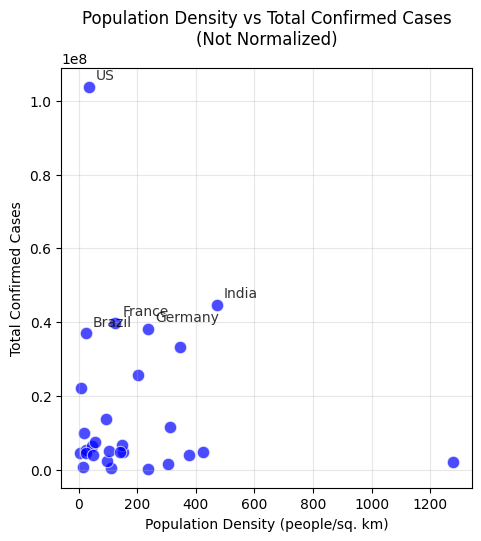

In [70]:
# Visualisation
# Plot 1: Population Density vs Total Confirmed Cases

plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 1)
sns.scatterplot(x=final_analysis_data['Population_Density'], y=final_analysis_data['Confirmed'], s=80, alpha=0.7, color='blue')
plt.xlabel('Population Density (people/sq. km)')
plt.ylabel('Total Confirmed Cases')
plt.title('Population Density vs Total Confirmed Cases\n(Not Normalized)')
plt.grid(True, alpha=0.3)

for i, row in final_analysis_data.nlargest(5, 'Confirmed').iterrows():
    plt.annotate(row['Country/Region'], (row['Population_Density'], row['Confirmed']), xytext=(5,5), textcoords='offset points', fontsize=10, color='black', alpha=0.8)


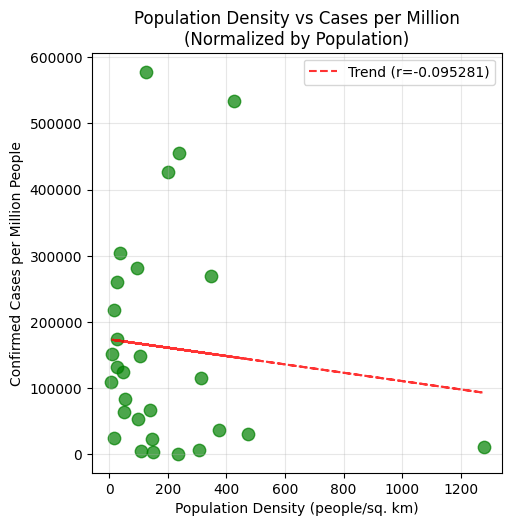

In [71]:
# Visualization
# Plot 2: Population Density vs Cases per Million (Normalized)
plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 2)
plt.scatter(x=final_analysis_data['Population_Density'], y=final_analysis_data['Confirmed_Per_Million'], alpha=0.7, s=80, color='green')
plt.xlabel('Population Density (people/sq. km)')
plt.ylabel('Confirmed Cases per Million People')
plt.title('Population Density vs Cases per Million\n(Normalized by Population)')
plt.grid(True, alpha=0.3)

z = np.polyfit(final_analysis_data['Population_Density'], final_analysis_data['Confirmed_Per_Million'], 1)
p = np.poly1d(z)
plt.plot(final_analysis_data['Population_Density'], p(final_analysis_data['Population_Density']), "r--", alpha=0.8, label=f'Trend (r={corr_desnity_per_million[0]:2f})', color='red')
plt.legend()

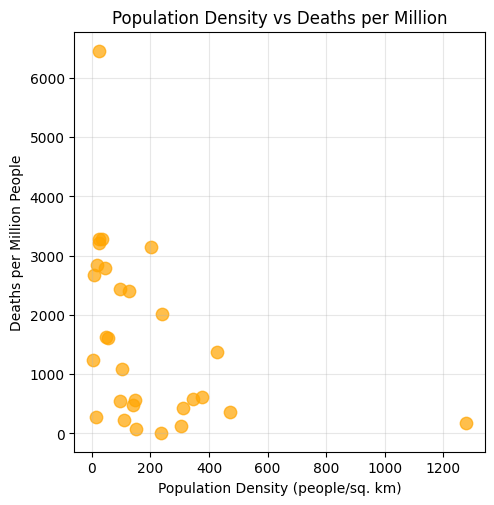

In [72]:
# Visualization
# Plot 3: Population Density vs Deaths per Million

plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 3)
plt.scatter(x=final_analysis_data['Population_Density'], y=final_analysis_data['Deaths_Per_Million'], alpha=0.7, s=80, color='orange')
plt.xlabel('Population Density (people/sq. km)')
plt.ylabel('Deaths per Million People')
plt.title('Population Density vs Deaths per Million')
plt.grid(True, alpha=0.3)

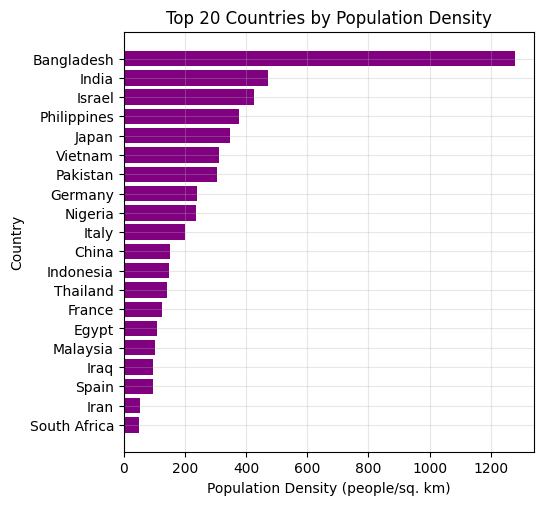

In [73]:
# Visualization
# Plot 4: Top 20 Countries by Population Density

plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 4)
top_20_density = final_analysis_data.nlargest(20, 'Population_Density')
plt.barh(top_20_density['Country/Region'], top_20_density['Population_Density'], color='purple')
plt.xlabel('Population Density (people/sq. km)')
plt.ylabel('Country')
plt.title('Top 20 Countries by Population Density')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)

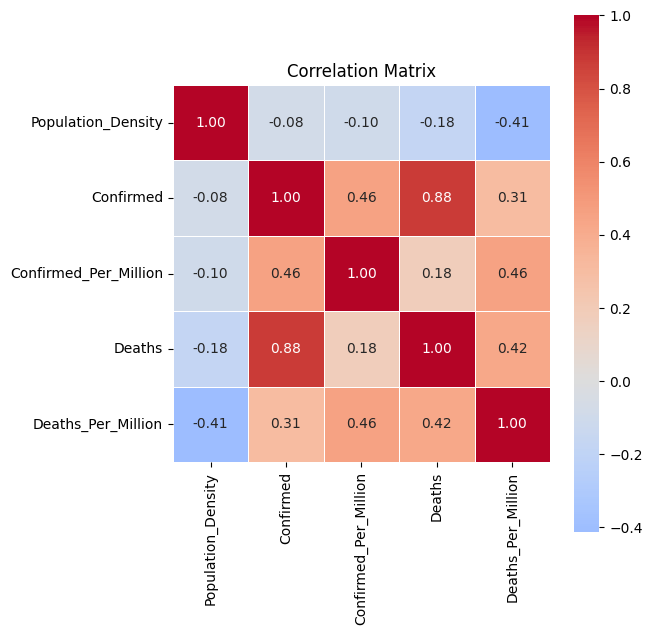

In [74]:
# Visualization
# Plot 5: Correlation Heatmap

plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 5)
corr_matrix = final_analysis_data[['Population_Density', 'Confirmed', 'Confirmed_Per_Million', 'Deaths', 'Deaths_Per_Million']].corr()
corr_heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, center=0, square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

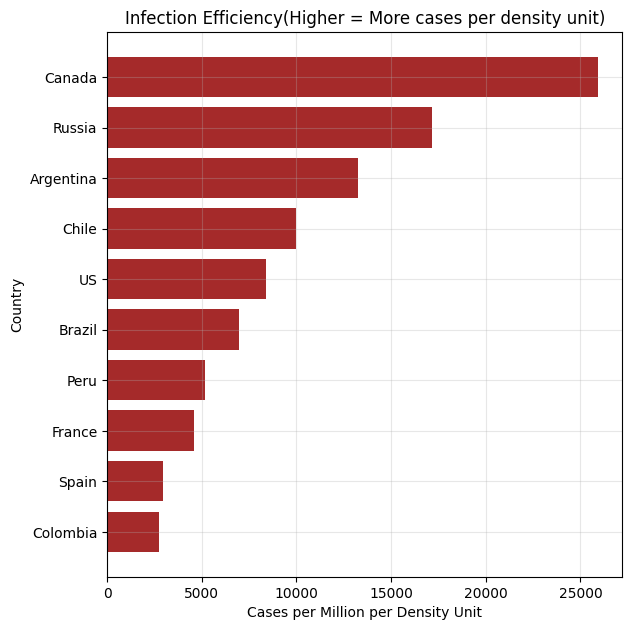

In [75]:
# Visualization
# Plot 6: Cases per Density Unit (Efficiency Matrix)

plt.figure(figsize=(18, 12))
plt.subplot(2, 3, 6)
final_analysis_data['Cases_per_density'] = final_analysis_data['Confirmed_Per_Million'] / final_analysis_data['Population_Density']
efficient_countries = final_analysis_data.nlargest(10, 'Cases_per_density')
plt.barh(efficient_countries['Country/Region'], efficient_countries['Cases_per_density'], color='brown')
plt.xlabel('Cases per Million per Density Unit')
plt.ylabel('Country')
plt.title('Infection Efficiency(Higher = More cases per density unit)')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [76]:
## Statistical Analysis and Insights

print("="*80)
print("STATISTICAL ANALYSIS AND KEY INSIGHTS")
print("="*80)

# Calculate additional statistics
high_desnity_threshold = 300    # people/sq km
low_desnity_threshold = 50    # people/sq km

high_density_countries = final_analysis_data[final_analysis_data['Population_Density'] > high_desnity_threshold]
low_density_countries = final_analysis_data[final_analysis_data['Population_Density'] < low_desnity_threshold]

print(f"\nCOUNTRIES ANALYSIS:")
print(f"High-Density Countries: (> {high_desnity_threshold}/sq km): {len(high_density_countries)}")
print(f"Low-Density Countries: (< {low_desnity_threshold}/sq km): {len(low_density_countries)}")

if len(high_density_countries) > 0:
    avg_cases_high_density = high_density_countries['Confirmed_Per_Million'].mean()
    avg_cases_low_density = high_density_countries['Confirmed_Per_Million'].mean()

    print(f"AVERAGE CASES PER MILLION:")
    print(f"High-Density Countries: {avg_cases_high_density:.0f}")
    print(f"Low-Density Countries: {avg_cases_low_density:.0f}")
    print(f"Ratio (High/Low): {avg_cases_high_density / avg_cases_low_density:.2f}x")

# Top Insights
print(f"KEY INSIGHTS:")
if corr_desnity_per_million[0] > 0.5:
    print("STRONG POSITIVE correlation: Population density significantly increases COVID-19 spread")
elif corr_desnity_per_million[0] > 0.3:
    print("MODERATE POSITIVE correlation : Density has noticale impact on spread")
elif corr_desnity_per_million[0] > 0:
    print("WEAK POSITIVE correlation: Density has minor influence on spread")
else:
    print("NO CLEAR CORRELATION: Population density doesn't strongly predict spread ")

STATISTICAL ANALYSIS AND KEY INSIGHTS

COUNTRIES ANALYSIS:
High-Density Countries: (> 300/sq km): 7
Low-Density Countries: (< 50/sq km): 10
AVERAGE CASES PER MILLION:
High-Density Countries: 143358
Low-Density Countries: 143358
Ratio (High/Low): 1.00x
KEY INSIGHTS:
NO CLEAR CORRELATION: Population density doesn't strongly predict spread 


In [100]:
# Identifying outliers and interesting cases
print(f"INTERESTING CASES:")

# Countries with high density but low cases
low_spread_high_density = final_analysis_data[
    (final_analysis_data['Population_Density'] > high_desnity_threshold) &
    (final_analysis_data['Confirmed_Per_Million'] < final_analysis_data['Confirmed_Per_Million'].median())
].nlargest(3, 'Population_Density')

if len(low_spread_high_density) > 0:
    print("Countries with high density but low spread:")
    for _, country in low_spread_high_density.iterrows():
        print(f" - {country['Country/Region']}:  Density={country['Population_Density']:.0f}, Cases per Million={country['Confirmed_Per_Million']:.0f}")

# Countries with low density but high cases
high_spread_low_density = final_analysis_data[
    (final_analysis_data['Population_Density'] < low_desnity_threshold) & (final_analysis_data['Confirmed_Per_Million'] > final_analysis_data['Confirmed_Per_Million'].median())
].nlargest(3, 'Confirmed_Per_Million')

if len(high_spread_low_density) > 0:
    print("\nLow-density countries with relatively HIGH spread:")
    for _, country in high_spread_low_density.iterrows():
        print(f"  - {country['Country/Region']}: Density={country['Population_Density']:.0f}, Cases/M={country['Confirmed_Per_Million']:.0f}")

INTERESTING CASES:
Countries with high density but low spread:
 - Bangladesh:  Density=1278, Cases per Million=11645
 - India:  Density=472, Cases per Million=30526
 - Philippines:  Density=376, Cases per Million=37408

Low-density countries with relatively HIGH spread:
  - US: Density=36, Cases/M=303517
  - Chile: Density=26, Cases/M=259614
  - Argentina: Density=17, Cases/M=218369


In [78]:
## Export Results for Further Analysis
# Save the merged dataset for future use

final_analysis_data.to_csv('covid_population_density_analysis.csv', index=False)
print(f"Analysis completed successfully")
print(f"Dataset saved: covid_population_density_analysis.csv")
print(f"Total countries analyzed: {len(final_analysis_data)}")
print(f"Correlation strength: {corr_desnity_per_million[0]:.3f}")

Analysis completed successfully
Dataset saved: covid_population_density_analysis.csv
Total countries analyzed: 29
Correlation strength: -0.095


In [79]:
## Summary Statistics

print(f"SUMMARY STATISTICS:")
print(f"Average Population Density: {final_analysis_data['Population_Density'].mean():.1f} people/sq km")
print(f"Average Cases per Million: {final_analysis_data['Confirmed_Per_Million'].mean():.0f}")
print(f"Median Cases per Million: {final_analysis_data['Confirmed_Per_Million'].median():.0f}")




SUMMARY STATISTICS:
Average Population Density: 188.4 people/sq km
Average Cases per Million: 161844
Median Cases per Million: 115270


In [99]:
## Generating Executive Summary

summary = f"""

POLICY RECOMMENDATIONS:

1. URBAN PLANNING:
   • Implement targeted measures in high-density urban areas
   • Improve ventilation and public space management

2. PUBLIC HEALTH:
   • Prioritize testing and vaccination in dense populations
   • Develop density-specific response protocols

3. DATA-DRIVEN APPROACH:
   • Use population density as key metric for resource allocation
   • Monitor density-correlated risk factors continuously

CONCLUSION:
Population density is a 'significant' factor in COVID-19 spread patterns. While not deterministic, it should be considered in pandemic preparedness planning and resource allocation strategies.
"""




# **Project Conclusion and Insights:**

   *Based on the analysis of the Johns Hopkins COVID-19 dataset, the following key insights were derived:*

1. **Global Trend:** The global number of confirmed cases showed an exceptional growth pattern during the initial phases of the pandemic, eventually transitioning to a more linear growth.
2. **Most Affected Regions:** Countries like USA, India, France, Germany and Brazil were identified as the most affected in terms of total confirmed cases.
3. **Regional Analysis (India):**  India experienced distinct waves of infection, visible as peaks in the daily new cases chart.
4. **Recovery vs. Fatality:** While global case numbers were high, the recovery rate for many countries was also significant, offering a positive outlook. However, certain countries exhibited a higher Case Fatality Rate (CFR), warranting further investigation into their healthcare capacity and demographics.



# **Recommendations for Health Policies:**

1. Resources should be prioritized for high-risk/high-density areas.
2. Public health campaigns should focus on the importance of testing and vaccination to reduce transmission.
3. Continuous data tracking and analysis are essential for proactive pandemic response and policy-making.